# Import the necessary modules

In [16]:
! pip3 uninstall torch -y
! pip3 install torch==1.7

Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
  Successfully uninstalled torch-1.7.0
  Using cached torch-1.7.0-cp38-none-macosx_10_9_x86_64.whl (108.1 MB)


In [17]:
!pip uninstall torchtext -y
!pip install -U torchtext==0.8

Found existing installation: torchtext 0.8.0
Uninstalling torchtext-0.8.0:
  Successfully uninstalled torchtext-0.8.0
  Using cached torchtext-0.8.0-cp38-cp38-macosx_10_9_x86_64.whl (1.5 MB)


In [42]:
import torch
import torch.nn as nn

from model.Model import Seq2Seq
from model.Encoder import Encoder
from model.Decoder import Decoder
from model.VisAwareTranslation import translate_sentence_with_guidance, postprocessing, get_all_table_columns
from preprocessing.build_vocab import build_vocab
from utilities.vis_rendering import VegaZero2VegaLite

from vega import VegaLite

import random
import numpy as np
import pandas as pd
import math
import sqlite3
from pprint import pprint 

In [43]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [44]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')  # cpu or gpu? depend on your computational environment.

In [4]:
device

device(type='cpu')

# Build vocab

In [5]:
print("------------------------------\n| Build vocab start ... | \n------------------------------")
SRC, TRG, TOK_TYPES, BATCH_SIZE, train_iterator, valid_iterator, test_iterator, my_max_length = build_vocab(
    data_dir='./dataset/dataset_final/',
    db_info='./dataset/database_information.csv',
    batch_size=128,
    max_input_length=128
)
print("------------------------------\n| Build vocab end ... | \n------------------------------")

------------------------------
| Build vocab start ... | 
------------------------------


/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release note

------------------------------
| Build vocab end ... | 
------------------------------


/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Construct ncNet model

In [6]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256  # it equals to embedding dimension 
ENC_LAYERS = 3 
DEC_LAYERS = 3 
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device,
              TOK_TYPES,
              my_max_length
              )

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              my_max_length
              )

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)  # define the transformer-based ncNet

# Load the trained ncNet model

In [7]:
model.load_state_dict(torch.load('./save_models/trained_model.pt', map_location=device))


<All keys matched successfully>

# Testing

## read the testing dataset

In [8]:
db_tables_columns = get_all_table_columns('./dataset/db_tables_columns.json')
db_tables_columns_types = get_all_table_columns('./dataset/db_tables_columns_types.json')

test_df = pd.read_csv('./dataset/dataset_final/test.csv')

# shuffle your dataframe in-place and reset the index
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [9]:
test_df.head()

,tvBench_id,db_id,chart,hardness,query,question,vega_zero,mentioned_columns,mentioned_values,query_template,source,labels,token_types
0,2914@y_name@DESC,swimming,Bar,Easy,"Visualize BAR SELECT name , ID FROM swimmer OR...",Draw a bar chart about the distribution of nam...,mark bar data swimmer encoding x name y aggreg...,id name time,NaN,mark bar data swimmer encoding x [X] y aggrega...,<N> Draw a bar chart about the distribution of...,mark bar data swimmer encoding x name y aggreg...,nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...
1,586,college_1,Bar,Easy,"Visualize BAR SELECT DEPT_CODE , sum(crs_credi...",Bar chart of sum crs credit from each dept code,mark bar data course encoding x dept_code y ag...,dept_code crs_credit,NaN,mark [T] data course encoding x [X] y aggregat...,<N> Bar chart of sum crs credit from each dept...,mark bar data course encoding x dept_code y ag...,nl nl nl nl nl nl nl nl nl nl nl nl template t...
2,2798@x_name@ASC,soccer_2,Bar,Medium,"Visualize BAR SELECT cName , min(enr) FROM col...",Return a bar graph for the name of the school ...,mark bar data college encoding x cname y aggre...,state cname enr,NaN,mark [T] data college encoding x [X] y aggrega...,<N> Return a bar graph for the name of the sch...,mark bar data college encoding x cname y aggre...,nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...
3,3051,train_station,Pie,Easy,"Visualize PIE SELECT Location , sum(number_of_...",Show the proportion of the total number of pla...,mark arc data station encoding x location y ag...,location number_of_platforms,NaN,mark [T] data station encoding x [X] y aggrega...,<N> Show the proportion of the total number of...,mark arc data station encoding x location y ag...,nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...
4,73,apartment_rentals,Pie,Easy,"Visualize PIE SELECT booking_status_code , COU...",How many bookings does each booking status hav...,mark arc data apartment_bookings encoding x bo...,booking_status_code,NaN,mark [T] data apartment_bookings encoding x [X...,<N> How many bookings does each booking status...,mark arc data apartment_bookings encoding x bo...,nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...


## testing and rendering the result using vega-lite

In [10]:
print(device)

cpu


In [50]:
only_nl_cnt = 0
only_nl_match = 0

nl_template_cnt = 0
nl_template_match = 0

query2vl = VegaZero2VegaLite()

for index, row in test_df.iterrows():
    
    gold_query = row['labels'].lower()
    src = row['source'].lower()
    

    tok_types = row['token_types']
    table_name = gold_query.split(' ')[gold_query.split(' ').index('data')+1]
    
    translation, attention, enc_attention = translate_sentence_with_guidance(
        row['db_id'], table_name, src, SRC, TRG, TOK_TYPES, tok_types, SRC, 
        model, db_tables_columns, db_tables_columns_types, device, my_max_length
    )

    pred_query = ' '.join(translation).replace(' <eos>', '').lower()
    old_pred_query = pred_query

    if '[t]' not in src:
        # with template

        nl_template_cnt += 1

        if ' '.join(gold_query.replace('"', "'").split()) == ' '.join(pred_query.replace('"', "'").split()):
            nl_template_match += 1
            
            predict_query = ' '.join(pred_query.replace('"', "'").split())                                                                     
            print('=========================================================\n')
            print('[Database]:\n', row['db_id'])
            print('[NL Question]:\n', row['question'])
            print('[Chart Template]:\n', row['query_template'])
            print('[Predicted VIS Query]:\n', predict_query)
            print('[The Ground Truth VIS Query]:\n', gold_query)
            ############ Query the VIS Result ############
            print('The Predicted VIS:')
            cnx = sqlite3.connect('./dataset/database/'+row['db_id']+'/'+row['db_id']+'.sqlite')
            table4vis = pd.read_sql_query("SELECT * FROM " + table_name, cnx)
            table4vis.columns = table4vis.columns.str.lower() # to lowercase
            pprint(VegaLite(query2vl.to_VegaLite(predict_query, table4vis)))
            print(json.dumps(query2vl.to_VegaLite(predict_query, table4vis))) # print the vega-lite spec
            print('\n')
            
        else:
            pass

    if '[t]' in src:
        # without template

        only_nl_cnt += 1
        if ' '.join(gold_query.replace('"', "'").split()) == ' '.join(pred_query.replace('"', "'").split()):  
            only_nl_match += 1
            
            predict_query = ' '.join(pred_query.replace('"', "'").split())      
            print('=========================================================\n')
            print('[Database]:\n', row['db_id'])
            print('[NL Question]:\n', row['question'])
            print('[Chart Template]:\n', row['query_template'])
            print('[Predicted VIS Query]:\n', predict_query)
            print('[The Ground Truth VIS Query]:\n', gold_query)
            ############ Query the VIS Result ############
            print('The Predicted VIS:')
            cnx = sqlite3.connect('./dataset/database/'+row['db_id']+'/'+row['db_id']+'.sqlite')
            table4vis = pd.read_sql_query("SELECT * FROM " + table_name, cnx)
            table4vis.columns = table4vis.columns.str.lower() # to lowercase
            print(VegaLite(query2vl.to_VegaLite(predict_query, table4vis)))
            print(json.dumps(query2vl.to_VegaLite(predict_query, table4vis))) # print the vega-lite spec
            print('\n')
            
        else:
            pass
    
    
    #show top-X testing cases.
    if index > 1:
        break


print("========================================================")
print('ncNet w/o chart template:', only_nl_match/only_nl_cnt)
print('ncNet with chart template:', nl_template_match/nl_template_cnt)
print('ncNet overall:',(only_nl_match+nl_template_match) / (only_nl_cnt+nl_template_cnt))




[Database]:
 swimming
[NL Question]:
 Draw a bar chart about the distribution of name and ID , I want to display from high to low by the Y-axis .
[Chart Template]:
 mark bar data swimmer encoding x [X] y aggregate [AggFunction] [Y] color [Z] transform filter [F] group [G] bin [B] sort [Y] desc topk [K]
[Predicted VIS Query]:
 mark bar data swimmer encoding x name y aggregate none id transform sort y desc
[The Ground Truth VIS Query]:
 mark bar data swimmer encoding x name y aggregate none id transform sort y desc
The Predicted VIS:
{"mark": "bar", "encoding": {"x": {"field": "name", "type": "nominal", "sort": "-y"}, "y": {"field": "id", "type": "quantitative"}}, "data": {"values": [{"id": 7, "name": "Przemys\u0142aw Sta\u0144czyk", "nationality": "Poland", "meter_100": 57.31, "meter_200": "1:57.10", "meter_300": "2:56.02", "meter_400": "3:55.36", "meter_500": "4:54.21", "meter_600": "5:52.59", "meter_700": "6:50.91", "time": "7:47.91"}, {"id": 4, "name": "Craig Stevens", "nationality"

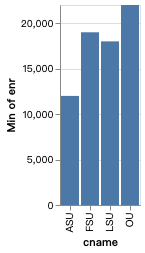

In [51]:
VegaLite(query2vl.to_VegaLite(predict_query, table4vis))